# Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("cancer_data.csv")

In [3]:
df.head(4)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097


In [4]:
df.shape

(100, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
id                   100 non-null int64
diagnosis_result     100 non-null object
radius               100 non-null int64
texture              100 non-null int64
perimeter            100 non-null int64
area                 100 non-null int64
smoothness           100 non-null float64
compactness          100 non-null float64
symmetry             100 non-null float64
fractal_dimension    100 non-null float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [6]:
df = df.replace("M", 1)

In [7]:
df = df.replace("B", 0)

In [8]:
df.head(4)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,1,23,12,151,954,0.143,0.278,0.242,0.079
1,2,0,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,1,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,1,14,16,78,386,0.070,0.284,0.260,0.097


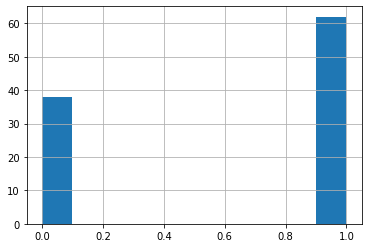

In [9]:
%matplotlib inline
df["diagnosis_result"].hist()

### Splitting data

In [10]:
x = df.drop("diagnosis_result", axis=1)

In [11]:
y = df["diagnosis_result"]

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

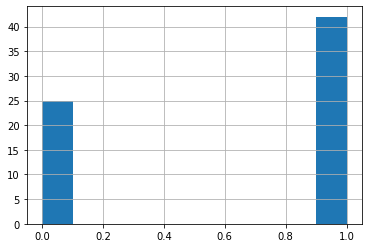

In [13]:
y_train.hist()

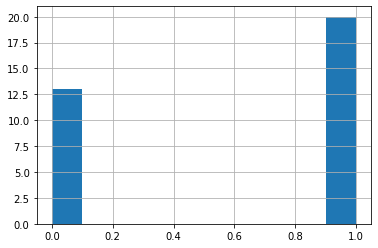

In [14]:
y_test.hist()

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [16]:
x_train = sc.fit_transform(x_train)

In [17]:
x_train = pd.DataFrame(data=x_train[:,1:],    # values
             index=range(0,67), 
              columns=x.columns[1:])
x_train.head(4)

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,-0.527005,1.776113,0.916088,0.984532,0.906981,0.335983,0.508431,-0.188917
1,-0.949872,0.948290,-0.084639,-0.223148,0.210902,1.148310,0.052496,1.039963
2,-0.104139,1.155246,0.374028,0.279272,0.141294,0.445334,0.215330,0.056859
3,-0.949872,-0.914312,-0.168033,-0.435350,0.767765,1.585717,0.443298,1.531515


In [18]:
x_train.shape

(67, 8)

# Feature selection

### K best

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

In [20]:
selector = SelectKBest(mutual_info_regression, k=4)

In [21]:
selector.fit(x_train, y_train)

SelectKBest(k=4,
            score_func=<function mutual_info_regression at 0x0000015A10A93798>)

In [22]:
selector.scores_

array([0.        , 0.02925074, 0.26991197, 0.2897641 , 0.01840877,
       0.23761696, 0.02775505, 0.08717424])

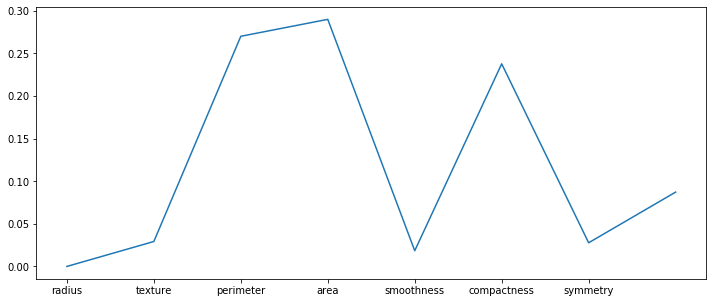

In [23]:
scores = selector.scores_
plt.rcParams["figure.figsize"] = [12,5]
plt.plot(scores)
plt.xticks(np.arange(7),list(x_train.columns));

- Perimeter
- Area
- Compactness
- fractal_dimension

### Ridge CV

In [24]:
from sklearn.linear_model import RidgeCV

In [25]:
crv = RidgeCV(store_cv_values=True)

In [26]:
fit = crv.fit(x_train, y_train)

In [27]:
fit.alpha_

1.0

In [28]:
var = np.floor(np.log10(np.abs(fit.coef_)))

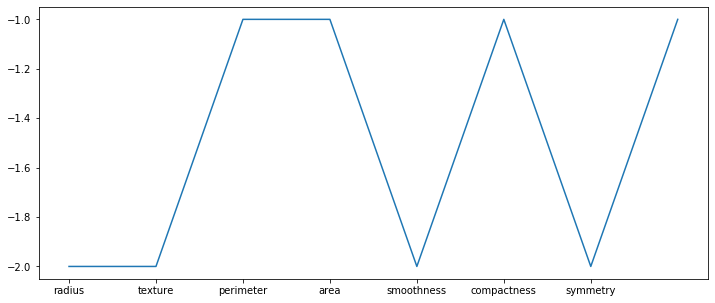

In [29]:
plt.rcParams["figure.figsize"] = [12,5]
plt.plot(var)
plt.xticks(np.arange(7),list(x_train.columns));

- Perimeter
- area
- compactness
- fractal_dimension

### Recursive Feature Elimination (RFE)

Es un método backward de selección, es decir que se van creando modelos y removiendo aquellos features que menos info aporten.

In [30]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold  #Hace que el set test y train esten estratificados
from sklearn.feature_selection import RFECV

In [31]:
rfc = RandomForestClassifier(random_state=101)

rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(x_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [32]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 8


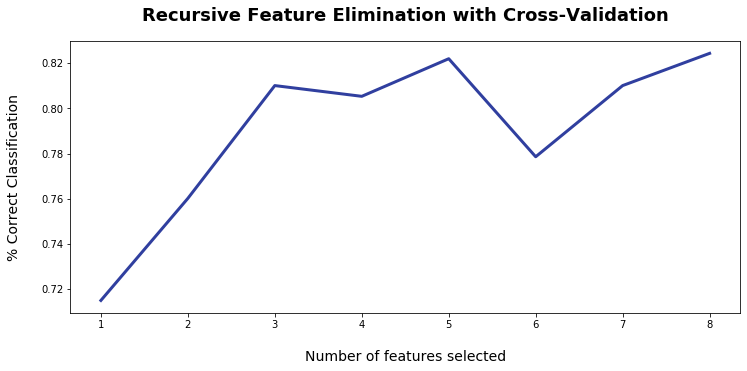

In [33]:
plt.figure(figsize=(12, 5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

- The performance of choising 3 and 5 variables is almost de same, then we chose 3 to reduce the complexity

In [34]:
dset = pd.DataFrame()
dset['attr'] = x_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

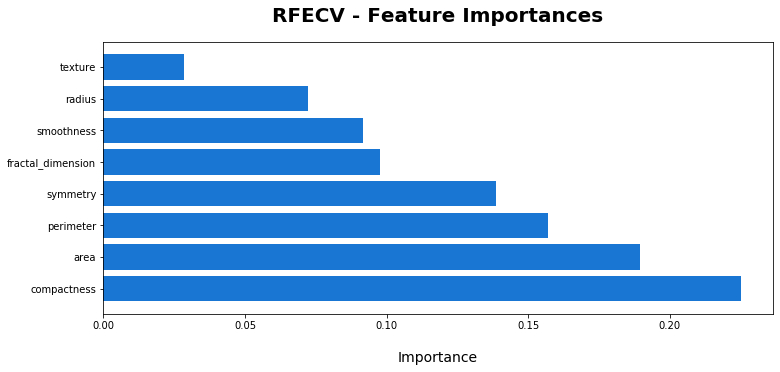

In [35]:
plt.figure(figsize=(12, 5))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

- compactness
- area
- perimeter
- symmetry

#### Choosed variables are: area, perimeter, compactness and fractal_dimension

In [36]:
x_test, x_train = (x_test[["area", "perimeter", "compactness", "fractal_dimension"]],
                   x_train[["area", "perimeter", "compactness", "fractal_dimension"]])

In [37]:
x_train.corr()

,area,perimeter,compactness,fractal_dimension
area,1.000000,0.971628,0.447421,-0.239045
perimeter,0.971628,1.000000,0.559076,-0.144321
compactness,0.447421,0.559076,1.000000,0.663771
fractal_dimension,-0.239045,-0.144321,0.663771,1.000000


- There is multicolinealitity between area and perimeter, then we delete on of those, in this case we delete perimeter

In [38]:
x_test, x_train = x_test.drop("perimeter", axis=1), x_train.drop("perimeter", axis=1)

# Modeling

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

- Logistic regression

In [40]:
results_1 = cross_validate(LogisticRegression(), x_train, y_train, return_train_score=True, cv=5)

In [41]:
test_scores = results_1['test_score']
train_scores = results_1['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.8733752620545072
0.8692307692307694


- SVM linear

In [42]:
from sklearn.svm import LinearSVC

In [43]:
results_2 = cross_validate(LinearSVC(), x_train, y_train, return_train_score=True, cv=5)

In [44]:
test_scores = results_2['test_score']
train_scores = results_2['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.8473794549266248
0.8076923076923078


- SVM poly degree=2

In [45]:
from sklearn.svm import SVC

In [46]:
results_3 = cross_validate(SVC(kernel="poly", degree=2, coef0=1, C=5), x_train, y_train, return_train_score=True, cv=5)

In [47]:
test_scores = results_3['test_score']
train_scores = results_3['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.8994409503843466
0.867032967032967


- DecisionTree

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
results_4 = cross_validate(DecisionTreeClassifier(max_depth=3), x_train, y_train, return_train_score=True, cv=5)

In [50]:
test_scores = results_4["test_score"]
train_scores = results_4["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.940461215932914
0.7934065934065935


- RandomForest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
results_5 = cross_validate(RandomForestClassifier(max_leaf_nodes=10), x_train, y_train, return_train_score=True, cv=5)

In [53]:
test_scores = results_5["test_score"]
train_scores = results_5["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9776380153738644
0.8824175824175825


- AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier

In [55]:
results_6 = cross_validate(AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=10),
                                              n_estimators=500, algorithm="SAMME.R",
                                              learning_rate=0.1), x_train, y_train, return_train_score=True, cv=5)

In [56]:
test_scores = results_6["test_score"]
train_scores = results_6["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

1.0
0.7945054945054946


- GradientBoosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

results_7 = cross_validate(GradientBoostingClassifier(max_depth=3, n_estimators=40, learning_rate=0.01), x_train, y_train,
                      return_train_score=True, cv=5)

In [58]:
test_scores = results_7["test_score"]
train_scores = results_7["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9255765199161425
0.8087912087912088


## Hyperparameter's optimization

### RandomForestClassifier

In [65]:
params = {"n_estimators": range(20, 400, 50),
           "max_features": ["auto","sqrt","log2"],
           "max_depth": range(2, 10, 1)}

In [74]:
from sklearn.model_selection import GridSearchCV

In [67]:
estimator = RandomForestClassifier()

In [68]:
ggrid = GridSearchCV(estimator, 
                     param_grid = params,
                     scoring="accuracy",
                     cv=5
                    )

In [69]:
final_model = ggrid.fit(x_train, y_train)

In [77]:
ggrid.cv_results_, ggrid.best_params_, ggrid.best_score_

({'mean_fit_time': array([0.02842798, 0.07419977, 0.12360735, 0.17681789, 0.25282879,
         0.31956038, 0.4004663 , 0.42277775, 0.02809625, 0.0844378 ,
         0.14283538, 0.1831522 , 0.31079535, 0.3613122 , 0.41596675,
         0.48844094, 0.03121252, 0.08922243, 0.16599164, 0.23147745,
         0.24879508, 0.42384644, 0.38128705, 0.45070362, 0.02695775,
         0.10158825, 0.20511045, 0.1998858 , 0.31569786, 0.31963434,
         0.39567833, 0.46688871, 0.03048463, 0.08686433, 0.14789672,
         0.22010345, 0.30278397, 0.30234003, 0.3556643 , 0.4030035 ,
         0.0256721 , 0.0787035 , 0.12991595, 0.18156171, 0.23698683,
         0.33172669, 0.33945918, 0.46210546, 0.02556114, 0.07367539,
         0.12020946, 0.20004463, 0.2463232 , 0.28555174, 0.36354566,
         0.45173349, 0.02360544, 0.08440466, 0.13899055, 0.20448861,
         0.25266056, 0.3361783 , 0.4053566 , 0.46136198, 0.03984485,
         0.09939404, 0.14211378, 0.19006157, 0.25391588, 0.29374514,
         0.368570

In [82]:
final_results = cross_validate(ggrid.best_estimator_, x_train, y_train, return_train_score=True, cv=5)

In [83]:
test_scores = final_results["test_score"]
train_scores = final_results["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9516422082459819
0.823076923076923


In [90]:
final_estimator = RandomForestClassifier(max_depth=3,
                                        max_features="auto",
                                        n_estimators=20)

In [91]:
final_estimator.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
final_estimator.score(x_test, y_test)

0.6060606060606061

## The choosed model is complex and overfit the data